## LAB 2 - OPTIONAL 1 TASK 1 submission. ML 2023-24.
FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**: Luis Calderón Robustillo 896238, Andrés Martínez Silva 904843


**SOURCE: This colab is based on the materials from Stanford Course - CS231CNNs for Visual Recognition with CNN by Fei-Fei Li**

You should **run this Colab in an instance WITHOUT GPU**! (recommended to save your GPU time)



# Implementing a Neural Network

In [ ]:
# DEFINITION OF THE CLASS for the 2-layer NN
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network that performs classification over C classes.
  The network has the following architecture:
  input - fully connected layer - ReLU - fully connected layer - softmax
  Input dimension of N, hidden layer dimension of H.
  Training uses a softmax loss function and L2 regularization (on the weights).

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights to small random values and biases to zero.
    Weights and biases are stored in the variable self.params,
    which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs to configure our network:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)


  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C.
      If it is None we only return scores; else return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function (with the same keys as self.params)
    """

    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape


    ## BEGINING OF FORWARD PASS ##
    # Q2. What's done in this block? (one line comment)
    # Compute the forward pass
    scores = None
    fc1 = X.dot(W1) + b1     # type of layer? fully connected
    X2 = np.maximum(0, fc1)  # type of layer? ReLU
    scores = X2.dot(W2) + b2 # type of layer? fully connected

    # If labels are not given skip the rest
    if y is None:
      return scores

    # Q3. What's done in this block? (one line comment)
    # Compute the loss (data loss - Softmax and L2 regularization)
    loss = None
    scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability
    scores_exp = np.exp(scores)
    softmax_matrix = scores_exp / np.sum(scores_exp, axis=1, keepdims=True)
    loss = np.sum(-np.log(softmax_matrix[np.arange(N), y]))
    loss /= N
    loss += reg * (np.sum(W2 * W2) + np.sum( W1 * W1 ))

    ## BEGINING OF BACKWARD PASS ##
    # Backward pass: compute gradients (derivatives of the weights and biases).
    # Fill up grads dictionary,
    # e.g., grads['W1'] is the gradient on W1 and both have the same size
    grads = {}
    softmax_matrix[np.arange(N) ,y] -= 1
    softmax_matrix /= N
    # W2 gradient
    dW2 = X2.T.dot(softmax_matrix)   # [HxN] * [NxC] = [HxC]
    # b2 gradient
    db2 = softmax_matrix.sum(axis=0)
    # W1 gradient
    dW1 = softmax_matrix.dot(W2.T)   # [NxC] * [CxH] = [NxH]
    dfc1 = dW1 * (fc1>0)             # [NxH] . [NxH] = [NxH]
    dW1 = X.T.dot(dfc1)              # [DxN] * [NxH] = [DxH]
    # b1 gradient
    db1 = dfc1.sum(axis=0)
    # regularization gradient
    dW1 += reg * 2 * W1
    dW2 += reg * 2 * W2

    grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}
    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    """
    Q4. WHAT IS THIS FUNCTION DOING?
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      # Q5. What's being done in this block? (one line comment)
      # random minibatch of training data and labels in X_batch and y_batch
      batch_indices = np.random.choice(num_train, batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      # Q6. What's being done in this block? (one line comment)
      # With the gradients in the grads dictionary, update the network params using SGD.
      for key in self.params:
        self.params[key] -= learning_rate * grads[key]

      if verbose and it % 10 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None
    #y_pred = np.argmax( self.function1(X), axis=1)
    y_pred = np.argmax( self.loss(X), axis=1)

    return y_pred

# Using the NN

# Load a real dataset
Now train the network on CIFAR-10

In [ ]:
from tensorflow.keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 dataset
    data_cifar10 = cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = data_cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [ ]:
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302955
iteration 100 / 1000: loss 2.302443
iteration 200 / 1000: loss 2.296468
iteration 300 / 1000: loss 2.267509
iteration 400 / 1000: loss 2.196704
iteration 500 / 1000: loss 2.121385
iteration 600 / 1000: loss 2.097593
iteration 700 / 1000: loss 2.004357
iteration 800 / 1000: loss 2.052496
iteration 900 / 1000: loss 2.065290
Validation accuracy:  0.284


# Debug the training
With the default parameters provided above, you should get a validation accuracy of about 0.20 on the validation set.

This isn't very good. Keep reading to improve the training.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

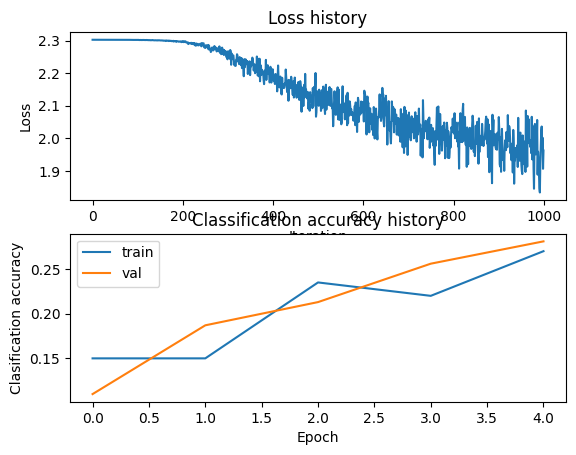

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

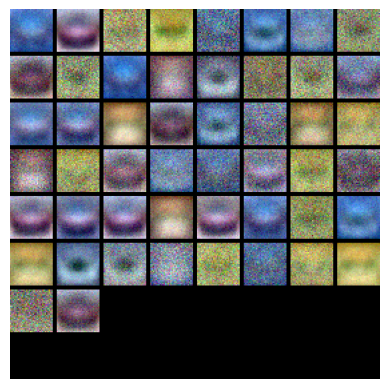

In [ ]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What can be wrong?**. In the visualizations above we see that the loss is decreasing more or less linearly which could be do to a learning rate too low. Besides, there is no significant gap between the training and validation accuracy, suggesting that the model used has low capacity, and we could increase its size. However, we need to be careful with very large models, where we would expect to see more overfitting. This can manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks.
To try to improve the results, next you will:
- run the training for more iterations (now we use 2000 instead of 1000)
- experiment with different values of  hidden layer size, learning rate and regularization strength.

Expect to achieve at most around 50% on the validation set. It's ok if you don't get to that. Just explain which hyperparameters you consider and why in the following question.



### **QUESTION 1** What list of possible values for lr, h and reg do you consider? why?

ANSWER 1: At the beggining I tried with lower and higer values of each hyperparameter. With these results I could see that, on the one hand, increasing the hidden layer size seem to help in the accuracy. On the other hand, the learning rate seem to be also too slow, I have tried higher values and the accuracy improved. Finally, regarding the regularization strength, I have tried high and lower values, and the results with less reg. values have less overfit.

In [ ]:
# This code explores different sets of hyperparameters and stores the best configuration

best_net = None # store the best model into this
best_val = -1
best_stats = []

# generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# get random hyperparameters given arrays of potential values
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

input_size = 32 * 32 * 3
num_classes = 10

############### ************* TO-DO-IN-LAB ************* ###############
num_random_iterations = 20   #When you have your lists of possible values ready, increase this to 20
lr_value_list = [0.0005, 0.0001, 0.000085]    # This is the initial value, add a list with up to 3 possible values
str_value_list = [0.05, 0.02, 0.001]     # This is the initial value, add a list with up to 3 possible values
h_value_list = [50, 75, 100]         # This is the initial value, add a list with up to 3 possible values
############### ************* END of TO-DO-IN-LAB ************* ###############

# Set a seed for results reproduction
np.random.seed(0)

# Use of random search for hyperparameter search
for i in range(num_random_iterations):
    lr, reg, hidden_size = random_search_hyperparams(lr_value_list, str_value_list, h_value_list)

    # Create a two-layer network
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == y_train).mean()

    # Predict on the validation set
    val_accuracy = (net.predict(X_val) == y_val).mean()

    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats

    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)


lr 5.000000e-04 reg 2.000000e-02 hid 50  train accuracy: 0.501878 val accuracy: 0.469000
lr 8.500000e-05 reg 1.000000e-03 hid 100  train accuracy: 0.351408 val accuracy: 0.347000
lr 1.000000e-04 reg 2.000000e-02 hid 50  train accuracy: 0.360878 val accuracy: 0.364000
lr 5.000000e-04 reg 1.000000e-03 hid 75  train accuracy: 0.512347 val accuracy: 0.481000
lr 5.000000e-04 reg 2.000000e-02 hid 75  train accuracy: 0.508347 val accuracy: 0.487000
lr 5.000000e-04 reg 1.000000e-03 hid 75  train accuracy: 0.509714 val accuracy: 0.487000
lr 5.000000e-04 reg 2.000000e-02 hid 75  train accuracy: 0.510531 val accuracy: 0.492000
lr 8.500000e-05 reg 5.000000e-02 hid 50  train accuracy: 0.344510 val accuracy: 0.340000
lr 8.500000e-05 reg 1.000000e-03 hid 100  train accuracy: 0.351388 val accuracy: 0.344000
lr 8.500000e-05 reg 5.000000e-02 hid 75  train accuracy: 0.344878 val accuracy: 0.335000
lr 8.500000e-05 reg 5.000000e-02 hid 100  train accuracy: 0.350837 val accuracy: 0.353000
lr 1.000000e-04 re

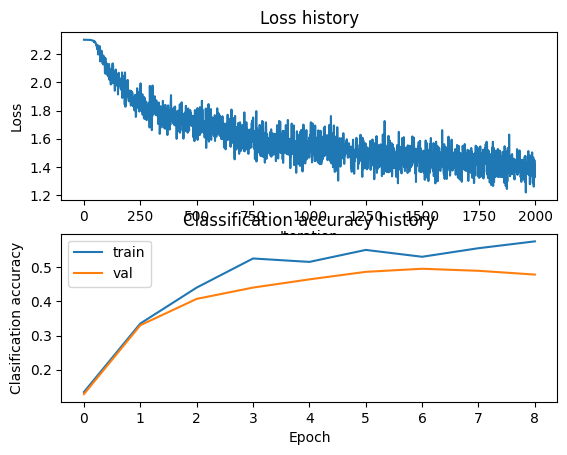

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

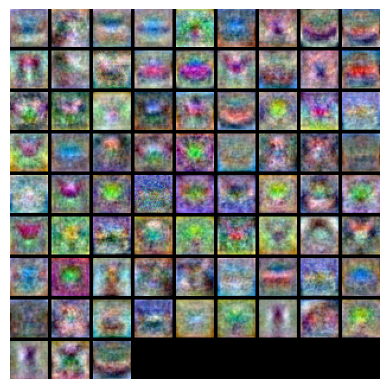

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [ ]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.4848


### **QUESTION 2**
When you find that your testing accuracy is much lower than the training accuracy. What can you do to try to fix it? Select all that apply and explain why (max 4 lines).
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. Start with very low values of learning rate
5. None of the above.

ANSWER 2:
The error seem to be an overfitting problem.

Train on a larger dataset: YES, maybe the data is not enough to identify the test cases and more training data could help to improve performance.

Add more hidden units: NO, Increase the hidden units can provoke more overfitting

Increase the regularization strength: YES, This could simplify the model and prevent overfitting.

Start with very low values of learning rate: NO, very low leraning rates could provoke that the model reach slow convergencies and and it could possibly find local minimas

OPTIONAL PART

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print()

Mounted at /content/drive



In [ ]:
####### ***** TO-DO-LAB *****  #######
# make sure you config these params to fit what you want/need to LOAD YOUR DATA
# dimensions we will use with our images (they'll be resized if not this shape)
img_width, img_height = 224, 224 # TO MATCH THE SIZES OF THE BASE MODEL WE WANT TO USE, MOBILENET
# MODIFY THE PATH TO POINT TO YOUR DATA! locally here or in your mounted drive
data_dir = '/content/drive/MyDrive/ML/lab2/oxford-iiit-pet/data' # all in one folder and let the system do the split
nb_train_samples = 2000 # UPDATE WITH YOUR NUMBERS!!
nb_validation_samples = 800 # UPDATE WITH YOUR NUMBERS!!
batch_size = 4 #16
num_classes = 5
####### ***** TO-DO-LAB *****  #######

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# for more optimized handling of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(len(train_ds))
for batch in train_ds:
    print(batch[0].shape)  # This will print the shape of the input images in the batch
    print(batch[1].shape)  # This will print the shape of the labels in the batch
    break  # Print only the first batch

print(len(val_ds))
for batch in val_ds:
    print(batch[0].shape)  # This will print the shape of the input images in the batch
    print(batch[1].shape)  # This will print the shape of the labels in the batch
    break  # Print only the first batch


Found 162 files belonging to 5 classes.
Using 130 files for training.
Found 162 files belonging to 5 classes.
Using 32 files for validation.
33
(4, 224, 224, 3)
(4,)
8
(4, 224, 224, 3)
(4,)


In [ ]:
def get_mydata(train_ds, val_ds):
    # Extract images and labels from the dataset
    X_train = []
    y_train = []
    for batch in train_ds:
        X_train.extend(batch[0].numpy())
        y_train.extend(batch[1].numpy())

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_val = []
    y_val = []
    for batch in val_ds:
        X_val.extend(batch[0].numpy())
        y_val.extend(batch[1].numpy())

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Normalize the data
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(len(X_train), -1)
    X_val = X_val.reshape(len(X_val), -1)

    return X_train, y_train, X_val, y_val

In [ ]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val = get_mydata(train_ds, val_ds)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Clear previously loaded data.
Train data shape:  (130, 150528)
Train labels shape:  (130,)
Validation data shape:  (32, 150528)
Validation labels shape:  (32,)


In [ ]:
input_size = 224 * 224 * 3
hidden_size = 50
num_classes = 5
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [ ]:
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=150, batch_size=128,
            learning_rate=8e-5, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 150: loss 1.628204
iteration 10 / 150: loss 1.625892
iteration 20 / 150: loss 1.619516
iteration 30 / 150: loss 1.601729
iteration 40 / 150: loss 1.508682
iteration 50 / 150: loss 1.405216
iteration 60 / 150: loss 1.180554
iteration 70 / 150: loss 0.950325
iteration 80 / 150: loss 0.678388
iteration 90 / 150: loss 0.584217
iteration 100 / 150: loss 0.426618
iteration 110 / 150: loss 0.366478
iteration 120 / 150: loss 0.308088
iteration 130 / 150: loss 0.202421
iteration 140 / 150: loss 0.156383
Validation accuracy:  0.46875


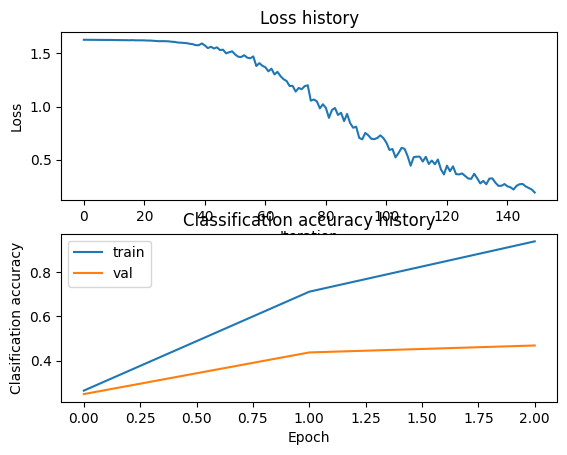

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

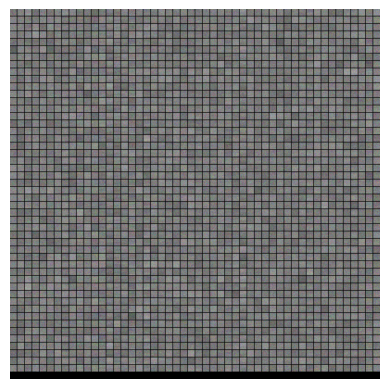

In [ ]:
show_net_weights(net)

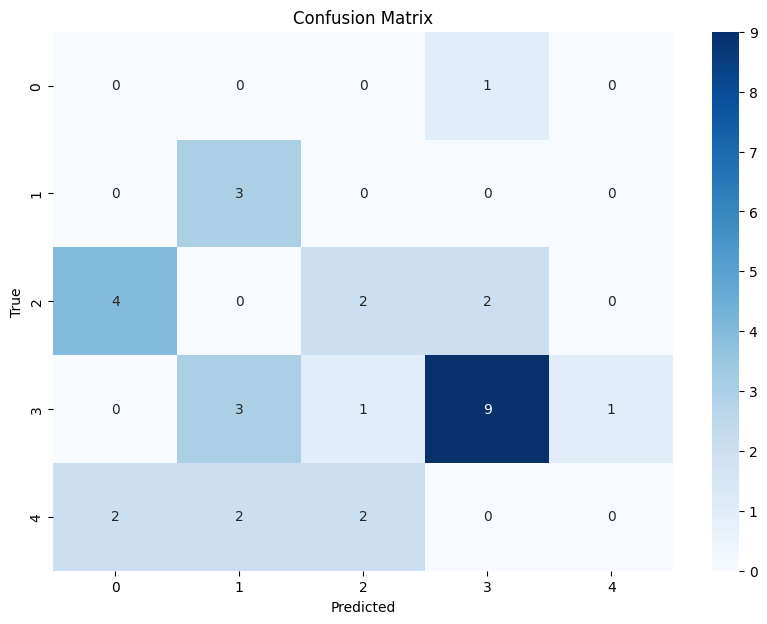

In [ ]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = net.predict(X_val)

cm = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# MODEL

To train our new model, we needed to adjust the input values of our two-layer network and explore more suitable hyperparameters for this specific application. Specifically, due to the limited amount of data, we had to reduce both the number of iterations (epochs) and the batch size. Additionally, in our pursuit of improved results, we made modifications to the learning rate, regularization, and hidden layer hyperparameters.

For the learning rate, we made a slight reduction to mitigate potential overfitting. We also experimented with higher values, but this did not yield notable gains.

In terms of regularization, we adjusted it in an effort to prevent overfitting, although it did not appear to be a prominent issue for this model, and it had only a marginal impact.

When it comes to the hidden layer, we explored various approaches. Initially, we hypothesized that our new data might be more complex, so we tried increasing the number of hidden layers. Ultimately, we also attempted decreasing it, but found that maintaining a similar configuration as before yielded the best results.

# Confusion matrix

Firstly, in the confusion matrix, it is evident that our model lacks accuracy, showing a high number of failures. Specifically, for the zeroth and fourth classes, the model seems to misclassified them, resulting in no successful predictions (although there was only one test for the zeroth class, which is insufficient for drawing definitive conclusions). On the other hand, there were relatively better success rates for the second and third classes, with 2 out of 8 correct predictions for the second class and 9 out of 14 for the third class. Additionally, for the first class, although there were fewer tests as with the zeroth class, the model achieved a perfect 3 out of 3 success rate.

This analysis leads us to a few conclusions. It appears that certain classes are inherently easier for the model to distinguish, even though there may be a scarcity of tests compared to other classes, limiting the depth of our conclusions.



In summary, it is clear that our model would benefit from either an increase in available data or the implementation of techniques such as data augmentation or fine-tuning to achieve more accurate class differentiation.